In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import mdtraj as md
import pandas as pd

## RDFs can then be used to calculate coordination number and cdfs or other forms of spatial distribution analysis. This analysis is ideal for predicting orientation of molecules based on which atoms are more likely to be at closer distances to each other than others BUT must be paired with other methods for more exact assessment of solvent structure!

First step is to load all of the necessary files for simulation analysis - these will have to be .h5 files. These files can be uploaded either by having this notebook in the folder where it is located or using the path as shown below

In [7]:
# Load the .h5 output file from MD simulation to be analyzed
HOH_traj = md.load_hdf5('/pikachu/homes/thaupt/Research/Alkyne_MD/opls/MD/HOH_sys/ppy_hoh/simulation_output/ppy-hoh_prod.h5')

Often, I have to trim my simulation files to remove the first ns, which acts as the final step of my equilibration. This may not be the case every time, but if a file ever has to be modified to exclude or skip snapshots which are insignficant for production analysis, you can use the code below:

In [5]:
T_HOH = HOH_traj[50:12550] # trim the first 1 ns of the trajectory
print(T_HOH)

T2 = HOH_traj[50:12550:100] # trim the first 1 ns of the trajectory and skip every 100th frame
print(T2)

<mdtraj.Trajectory with 12500 frames, 8521 atoms, 2839 residues, and unitcells>
<mdtraj.Trajectory with 125 frames, 8521 atoms, 2839 residues, and unitcells>


In [13]:
# Load topology for atom and residue info
top_HOH = T_HOH.topology

Next step, once trajectory is loaded, is to specifiy the atoms in the system which you will be referring to for rdf calculations:

In [8]:
# Reference alkyne probe (solute) atoms
PPY_H_HOH = [atom.index for atom in top_HOH.atoms
         if atom.name == 'H02' and atom.residue.name == 'PPY']
PPY_C_HOH = [atom.index for atom in top_HOH.atoms
         if (atom.name == 'C00' or atom.name == 'C01') and atom.residue.name == 'PPY']

# Reference solvent atoms
HOH_H = [atom.index for atom in top_HOH.atoms 
             if atom.element.symbol == 'H' and atom.residue.name == 'HOH']
HOH_O = [atom.index for atom in top_HOH.atoms 
             if atom.element.symbol == 'O' and atom.residue.name == 'HOH']

In order to create the pairwise correlations, you must specify the two atoms being compared. This is done with mdtraj.Topology attributes/methods. The method used is mdtraj.Topology.select_pairs which generates unique pairs of atom indices.

In [12]:
# HOH atoms to PPY terminal H atom
probeH_solvH = top_HOH.select_pairs(PPY_H_HOH,HOH_H)
probeH_solvO = top_HOH.select_pairs(PPY_H_HOH,HOH_O)

In [11]:
# Print example of the array generated for atom pairs between probe-H and solvent-O. 
# There is an array of every HOH O atom paired with the single PPY H atom
probeH_solvO

array([[   2,    7],
       [   2,   10],
       [   2,   13],
       ...,
       [   2, 8512],
       [   2, 8515],
       [   2, 8518]], dtype=int32)

The following steps are oriented towards preparing the rdf calculation. This will require a term known as bin_width, which specifies the intervals or "bins" at which distances between atoms are separated (range of distance from atom A to atom B). This can be adjusted in your analysis to increase or decrease data points, usually used for obtaining a smoother curve. If the bin is too small, the plot will have too much noise due to insufficient amounts of data. If the bin is too large, you risk lower resolution and potentially skipping over important peaks/distances.

The x_min and x_max values go into the exact calculation. You can modify these values to choose which values the rdf calc starts on. 

In [14]:
# set RDF variables
bin_width = 0.009  #sets the bin width for RDF analysis
x_min = 0.0
x_max = 1.5

We use MDTraj to compute RDFs as shown below. The parts of this line of code which you will have to change for your systems are noted here:

* r_OH_H = r values for x-axis
* gr_OH_H = RDF or "probability" g(r) for y-axis
* T_HOH = trajectory defined in above cells; CHANGE FOR YOUR TRAJ
* probeH_solvO = pairwise indices for atoms which distances will be calculated between; CHANGE FOR ATOMS BEING LOOKED AT
* r_range = range of r values for minimum and maximum radii, will likely be unable to go over the maximum radius based on your box size
* bin_width = bins as defined above, widths in nm

In [24]:
# Compute RDF

# Relations between probe-H/solvent-O
rOH_H, grOH_H = md.compute_rdf(
    T_HOH,
    probeH_solvO, 
    r_range=(x_min,x_max),
    bin_width=bin_width)

rOH_H = rOH_H*10

# Relations between probe-H/solvent-H
rHH_H, grHH_H = md.compute_rdf(
    T_HOH,
    probeH_solvH, 
    r_range=(x_min,x_max),
    bin_width=bin_width)

rHH_H = rHH_H*10

In [25]:
# Example of what r values output would look like to go on x-axis
rOH_H

array([ 0.04518072,  0.13554217,  0.22590362,  0.31626508,  0.4066265 ,
        0.49698797,  0.5873494 ,  0.67771083,  0.7680723 ,  0.8584337 ,
        0.9487952 ,  1.0391567 ,  1.129518  ,  1.2198795 ,  1.310241  ,
        1.4006025 ,  1.4909638 ,  1.5813253 ,  1.6716868 ,  1.7620482 ,
        1.8524096 ,  1.9427711 ,  2.0331326 ,  2.123494  ,  2.2138553 ,
        2.3042169 ,  2.3945782 ,  2.4849398 ,  2.5753012 ,  2.6656628 ,
        2.756024  ,  2.8463855 ,  2.936747  ,  3.0271082 ,  3.1174698 ,
        3.2078314 ,  3.2981925 ,  3.3885546 ,  3.4789157 ,  3.5692768 ,
        3.659639  ,  3.75      ,  3.840361  ,  3.9307232 ,  4.0210843 ,
        4.1114454 ,  4.2018075 ,  4.2921686 ,  4.38253   ,  4.472892  ,
        4.563253  ,  4.6536145 ,  4.743976  ,  4.834337  ,  4.924699  ,
        5.0150604 ,  5.1054215 ,  5.1957836 ,  5.2861447 ,  5.376506  ,
        5.4668674 ,  5.557229  ,  5.64759   ,  5.737952  ,  5.8283134 ,
        5.9186745 ,  6.009036  ,  6.0993977 ,  6.189759  ,  6.28

In [26]:
# Example of what rdf values output would look like to go on y-axis
grOH_H

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00285849, 0.02673773,
       0.10317898, 0.2705081 , 0.45576859, 0.63231532, 0.75737051,
       0.83637069, 0.8952263 , 0.95607159, 1.02246981, 1.07371091,
       1.10364154, 1.14630705, 1.1524144 , 1.13043181, 1.13665555,
       1.09293153, 1.08337235, 1.04100179, 1.00286918, 0.98860566,
       0.94829508, 0.90393078, 0.88668156, 0.86459428, 0.85084566,
       0.838223  , 0.83208186, 0.82894248, 0.84283149, 0.84877695,
       0.86493218, 0.87185058, 0.87864   , 0.8896794 , 0.91406665,
       0.93614822, 0.94191425, 0.97184128, 0.98264862, 0.98694436,
       0.99942746, 0.99768068, 1.01286016, 1.01390558, 1.02192825,
       1.03295026, 1.04008746, 1.03161312, 1.05157204, 1.04823

Now that the rdf has been computed, you can take these values and create a plot to better visualize how these atoms correlate to each other. This plot is commonly seen in literature as one form of spatial distribution for analyzing MD simulations. It can also be used to validate MD simulations in some instances.

* Be sure to multiply the r values by 10 to ocnvert units from nm to Angstroms!!!

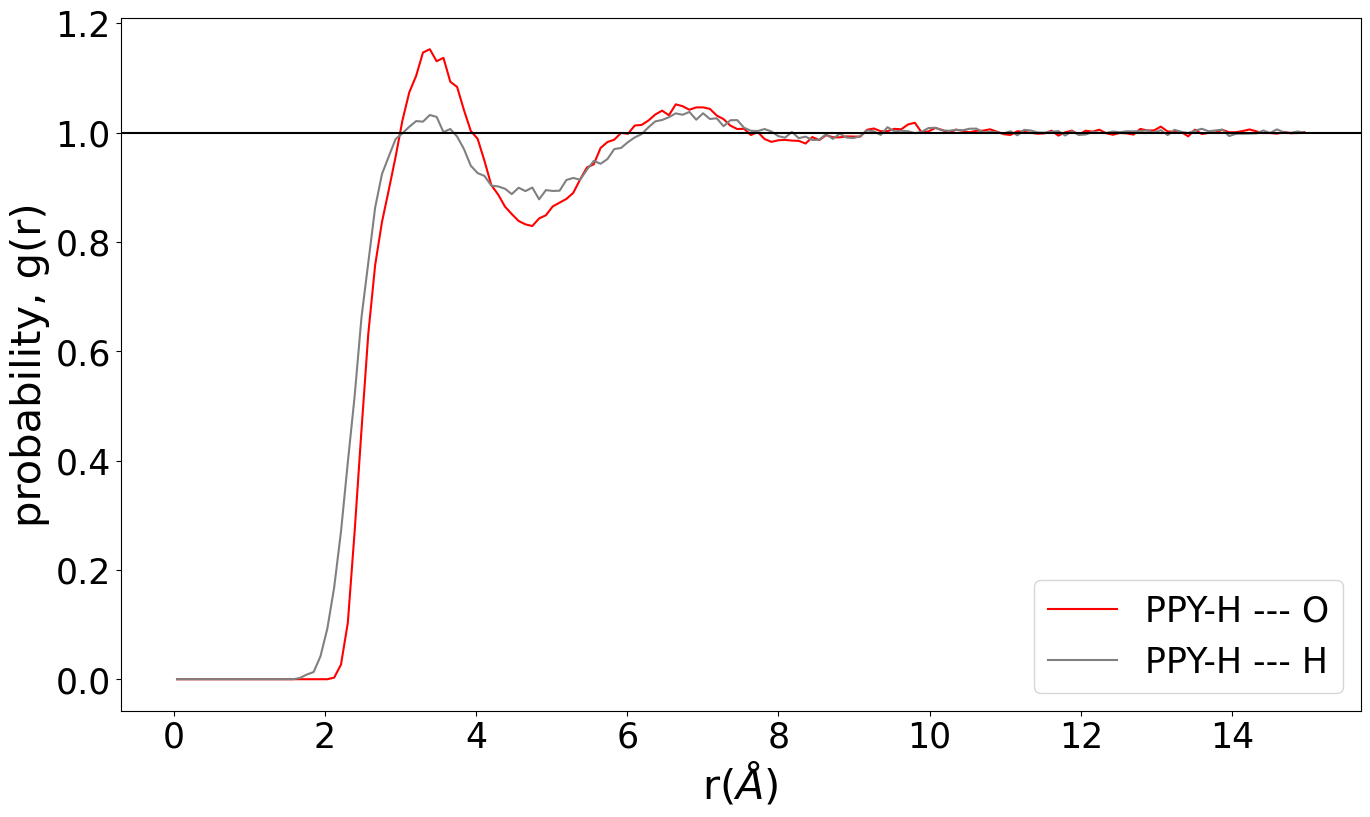

In [27]:
plt.figure(figsize=(16, 9))

plt.plot(rOH_H,grOH_H, color = 'red', linestyle = 'solid') #PPY-H --- solv-O
plt.plot(rHH_H,grHH_H, color = 'grey', linestyle = 'solid') #PPY-H --- solv-H

#Plot line for y = 1 where the probability of an atom being located at that distance matches what is expected for your system
plt.axhline(y=1, color='black', linestyle='solid')

#plt.xlim([1, 8])
#plt.ylim([0,2.6])

plt.xlabel(r'r($\AA$)',fontsize='30')
plt.ylabel('probability, g(r)',fontsize='30')
#plt.title('RDF for Probe-C and TEA-N')
plt.legend(['PPY-H --- O', 'PPY-H --- H'], fontsize=25)

plt.xticks(fontsize='25')
plt.yticks(fontsize='25')
#plt.savefig('H-RDF_PAC-DCM.pdf', bbox_inches='tight')
plt.show()